In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import cv2
import json
from PIL import Image

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [2]:
import tensorflow as tf
tf.random.set_seed(42)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,GlobalAveragePooling2D,Input
from keras.utils import plot_model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
!nvidia-smi
!nvcc -V

2023-10-17 14:02:56.089237: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 14:02:56.089275: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 14:02:56.090480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 14:02:56.154905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 14:02:56.892622: W tensorflow/

Num GPUs Available:  1
Tue Oct 17 14:02:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8               2W /  80W |    120MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

2023-10-17 14:02:57.873924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 14:02:57.943665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 14:02:57.943701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [80]:
class_names = ["signature", "stamp", "logo", "text"]
errors = []
for name in tqdm(class_names):
    images = os.listdir(f"SPODS_Dataset/")
    count = 0
    for image in images:
        try:
            axis = pd.read_csv("signture axis/" + image[:-4].replace(" ","") + ".csv")
            axis = axis.iloc[class_names.index(name)].values[5]
            axis = json.loads(axis)
            img = cv2.imread(f"SPODS_Dataset/"+image)
            img = img[axis["y"]:axis["y"]+axis["height"], axis["x"]:axis["x"]+axis["width"]]
            ones = np.count_nonzero(img)
            if ones < 0:
                errors.append(f"{name}     :      ||     {image}     ||     ones_count")
            else:
                cv2.imwrite(f"Dataset/{name}/{count}.png", img)
                count += 1
        except Exception as e:
            errors.append(f"{name}     :      ||     {image}     ||     missing axis" + str(e))
            pass
print("Done")
print("Errors : " + f"{len(errors)}")
for error in errors:
    print(error)

100%|██████████| 4/4 [03:08<00:00, 47.25s/it]

Done
Errors : 34
signature     :      ||     image (528).png     ||     missing axissingle positional indexer is out-of-bounds
stamp     :      ||     image (528).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1059).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1058).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1060).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (528).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1072).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1063).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     image (1065).png     ||     missing axissingle positional indexer is out-of-bounds
logo     :      ||     ima

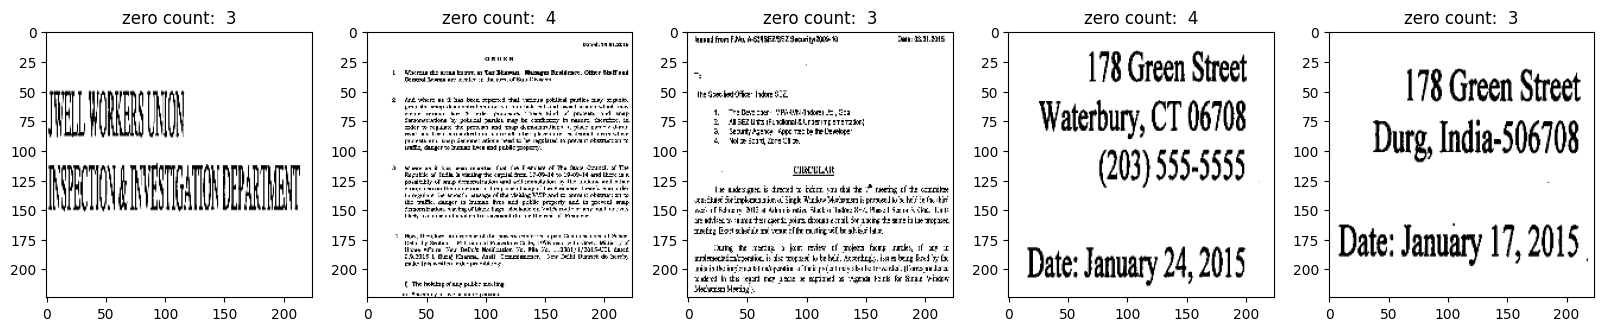

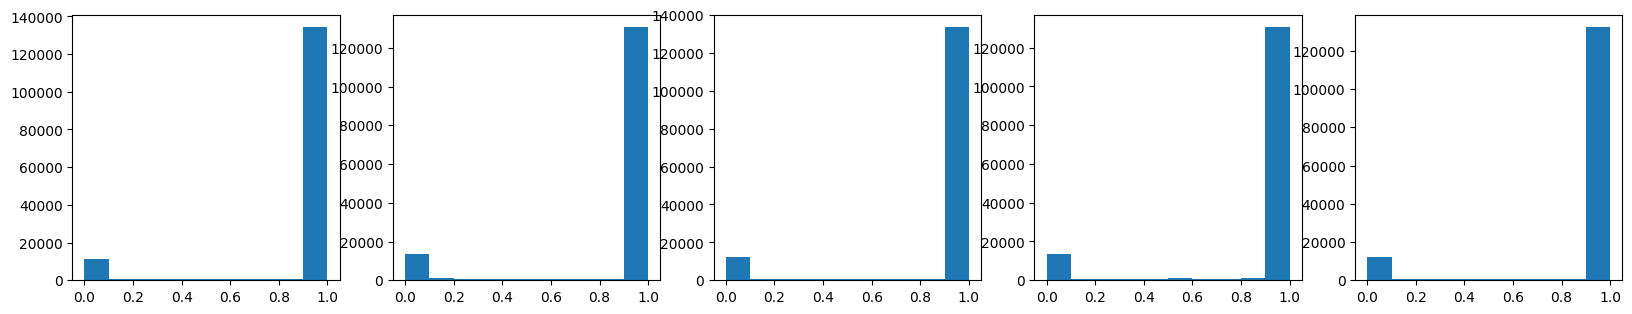

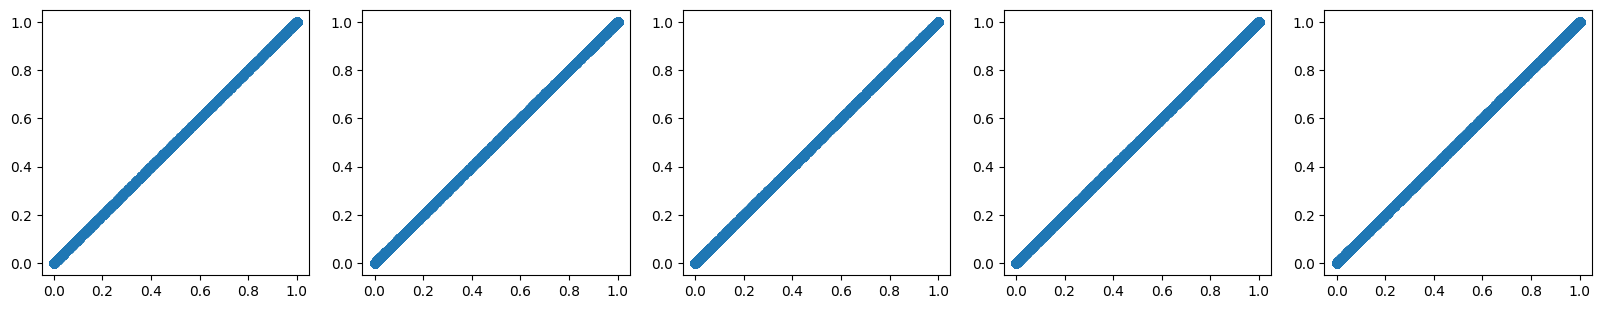

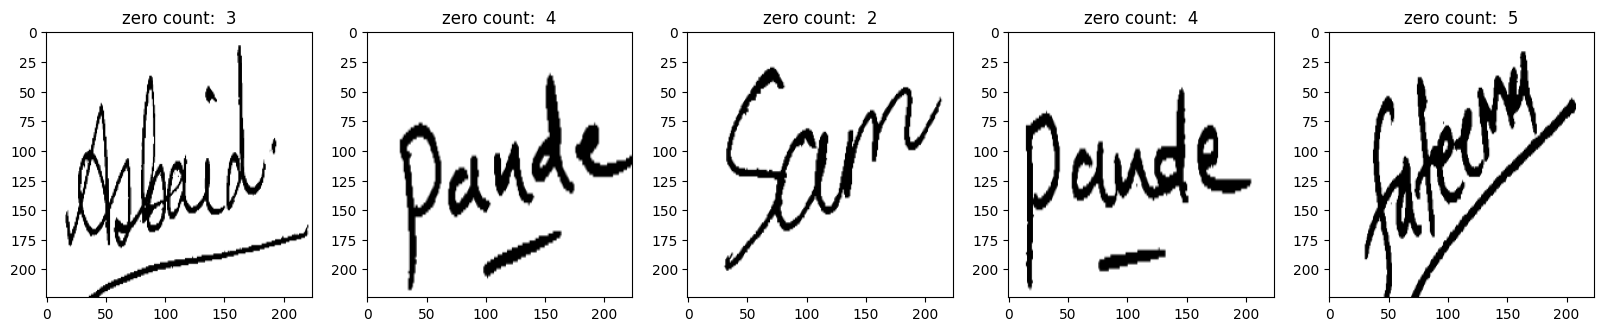

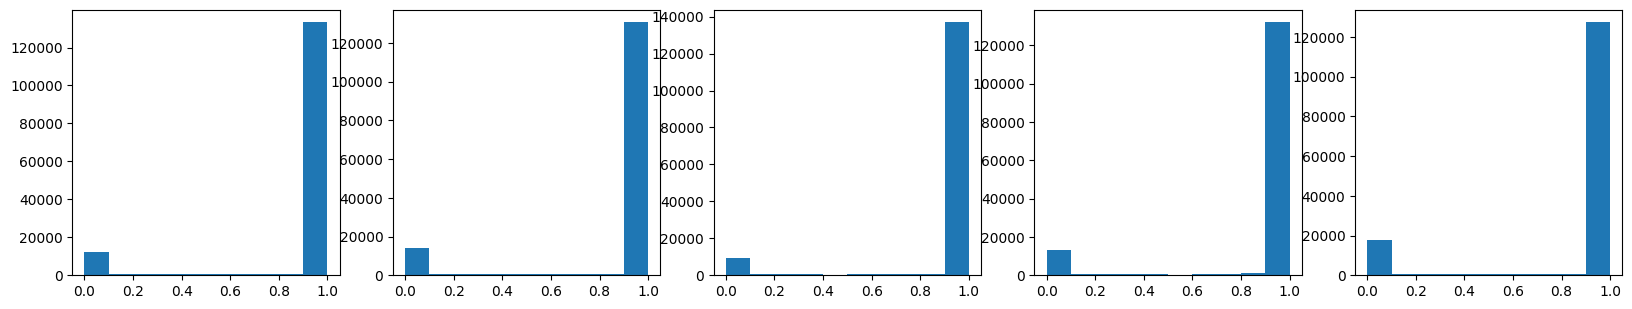

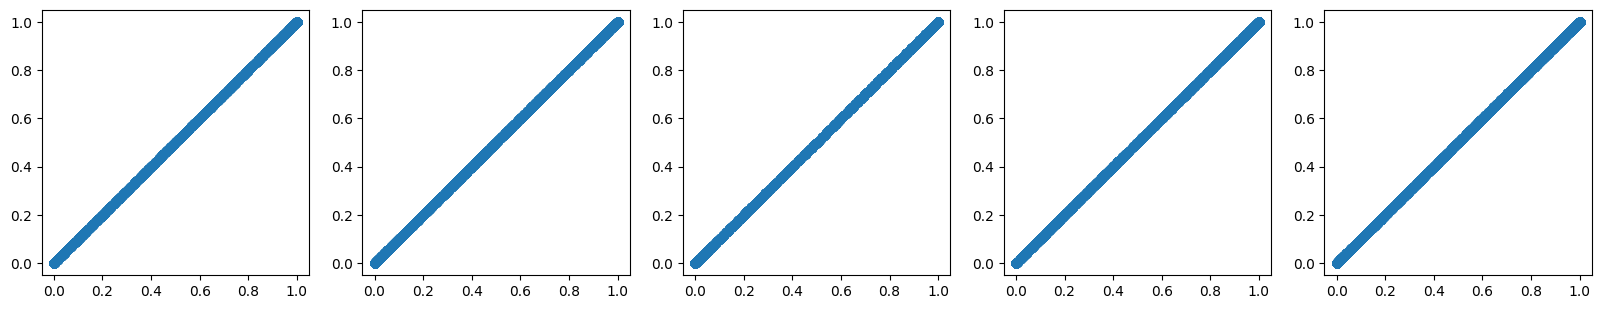

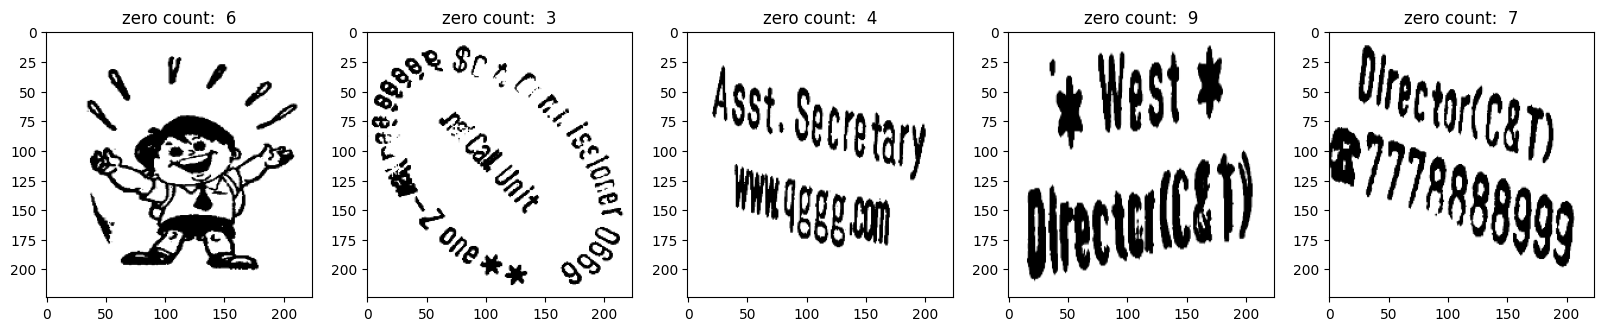

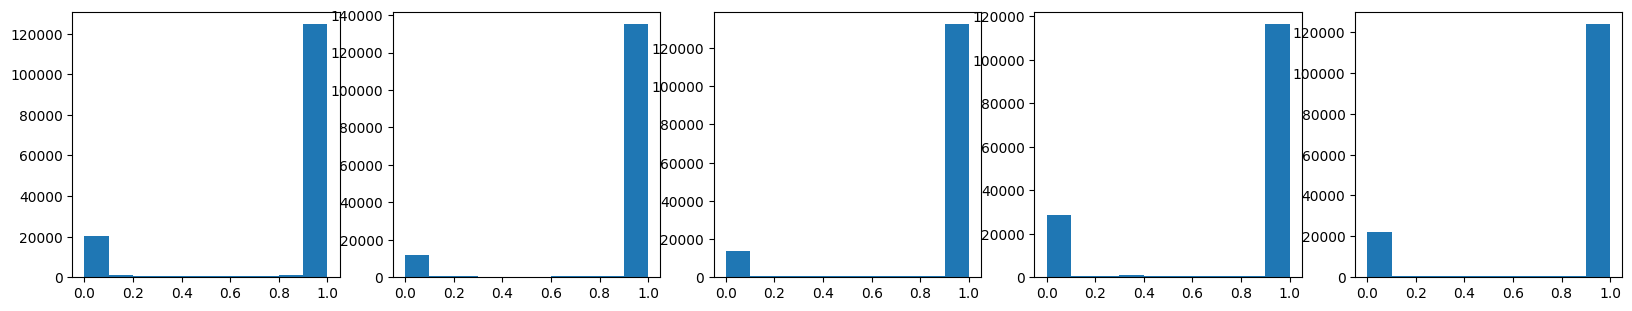

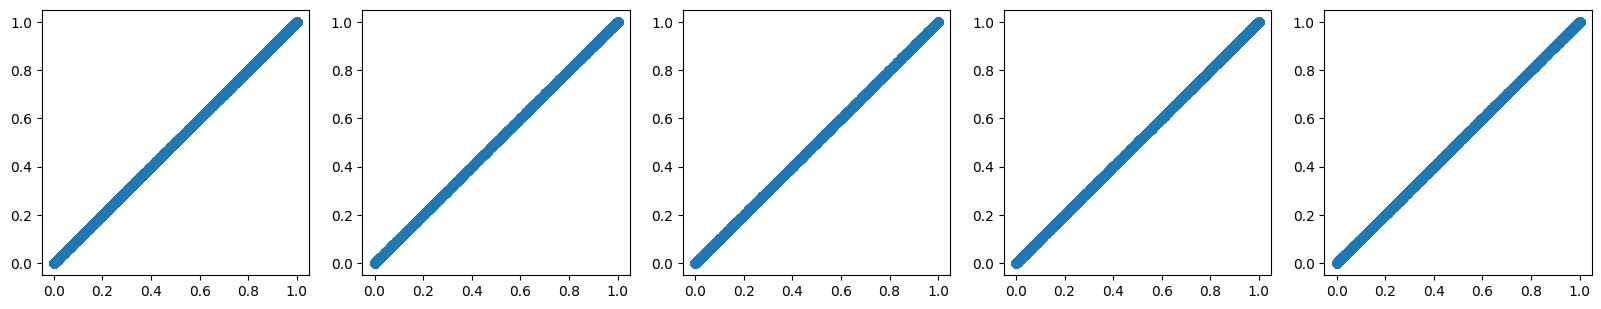

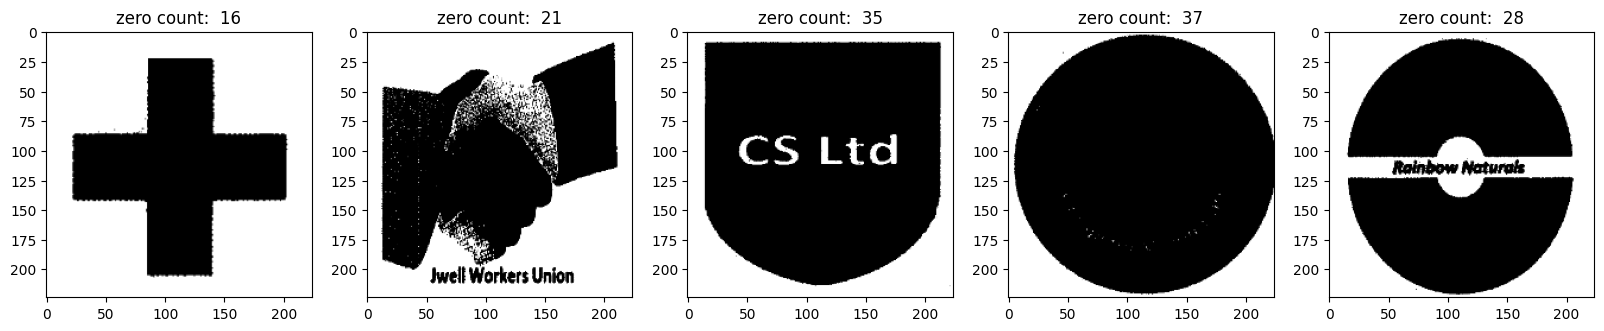

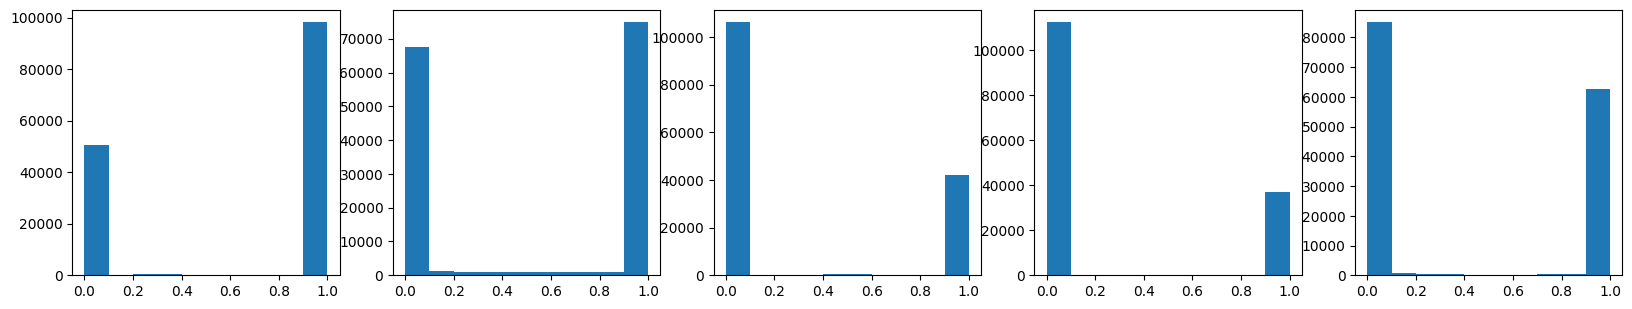

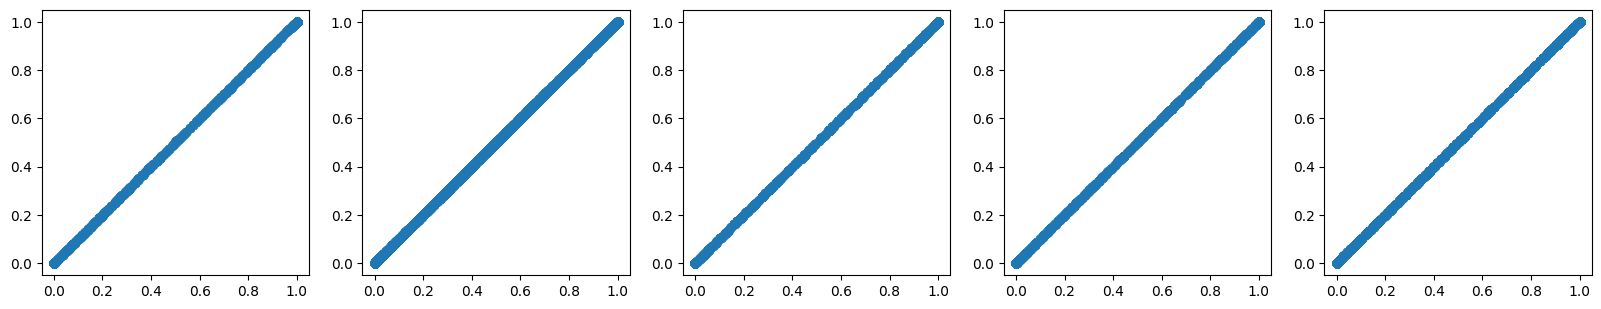

In [184]:
paths = ["Dataset/text","Dataset/signature", "Dataset/stamp","Dataset/logo"]

pixels_pos = []
for path in paths:
    photos = os.listdir(path)
    plt.figure(figsize=(20, 20))
    for i in range(0, 5):
        plt.subplot(5, 5, i+1)
        img = plt.imread(path + "//" + photos[i])
        # convert to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224, 224))
        plt.imshow(img, cmap="gray")
        psum = np.sum(img)
        zero_count = np.count_nonzero(img == 0)
        plt.title("zero count: " + f" {zero_count//1000}")
        # plt.axis("off")
    plt.show()


    plt.figure(figsize=(20, 20))
    for i in range(0, 5):
        plt.subplot(5, 5, i+1)
        img = plt.imread(path + "//" + photos[i])
        img = cv2.resize(img, (224, 224))
        plt.hist(img.ravel())
        # plt.axis("off")
    plt.show()

    
    plt.figure(figsize=(20, 20))
    for i in range(0, 5):
        plt.subplot(5, 5, i+1)
        img = plt.imread(path + "//" + photos[i])
        img = cv2.resize(img, (224, 224))
        plt.scatter(img[:, :, 0].ravel(), img[:, :, 1].ravel())
        # plt.axis("off")
    plt.show()

In [3]:
dataset_path = "Dataset"
class_names = ["signature", "stamp", "logo", "text"]
image_data = []
labels = []

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    for image_file in tqdm(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        zero_count = np.count_nonzero(image == 0)
        if zero_count < 100:
            image_data.append(image)
            labels.append(class_names.index(class_folder))
        else:
            pass

100%|██████████| 1065/1065 [00:12<00:00, 84.86it/s]


In [4]:
image_data = np.array(image_data)
labels = np.array(labels)
labels = tf.keras.utils.to_categorical(labels, num_classes=4)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

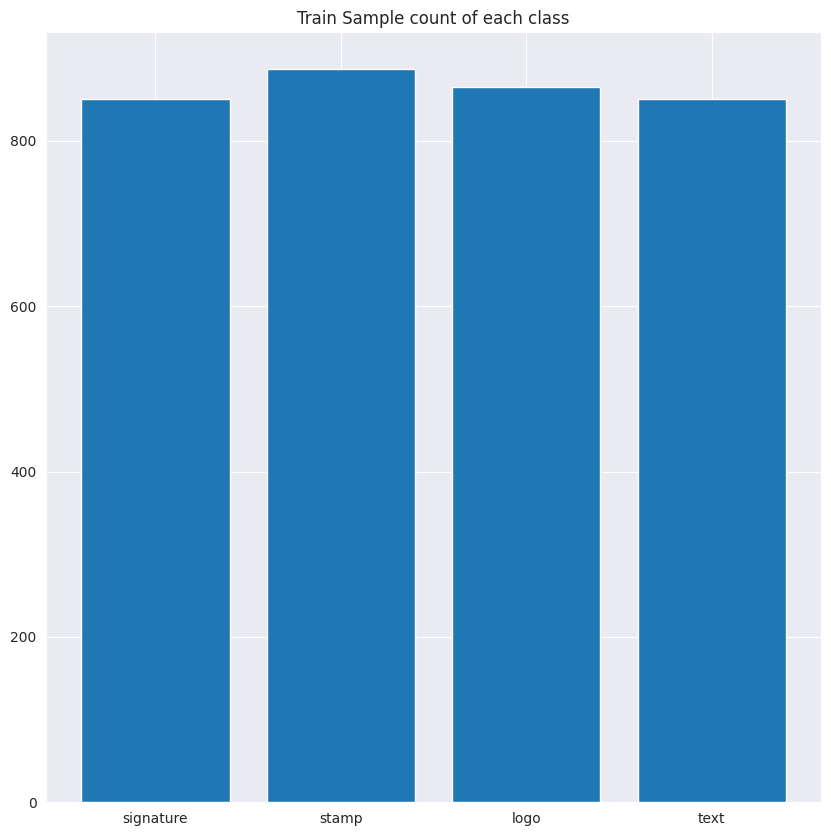

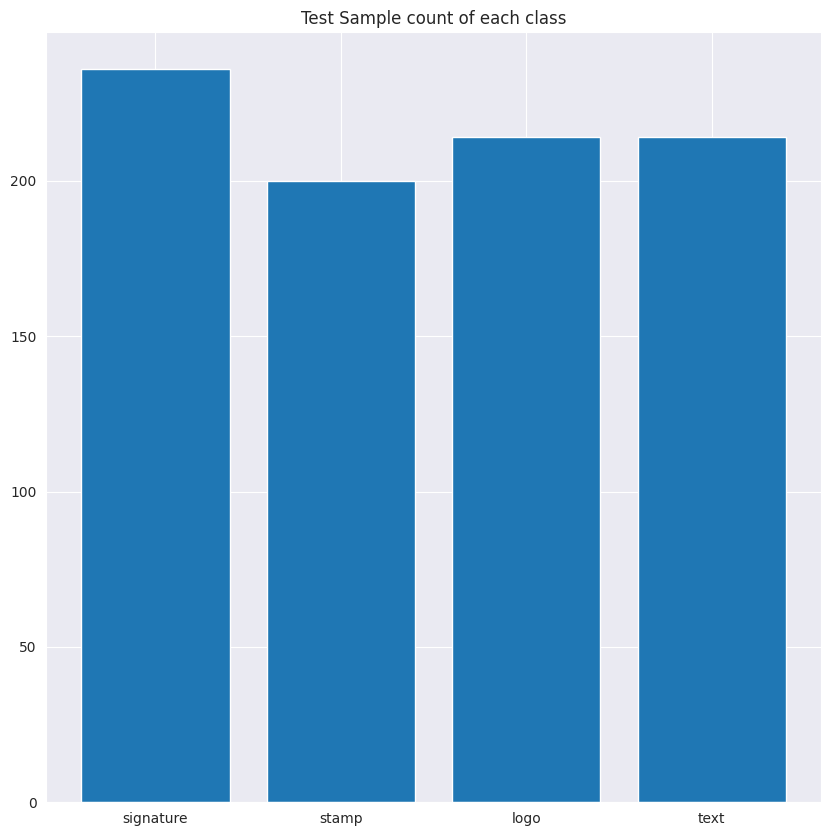

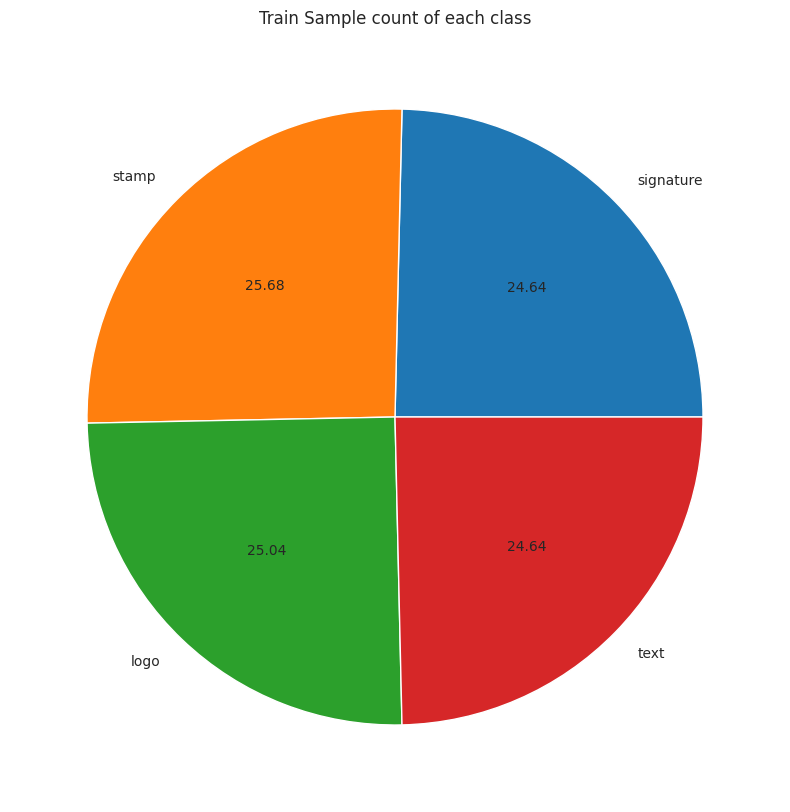

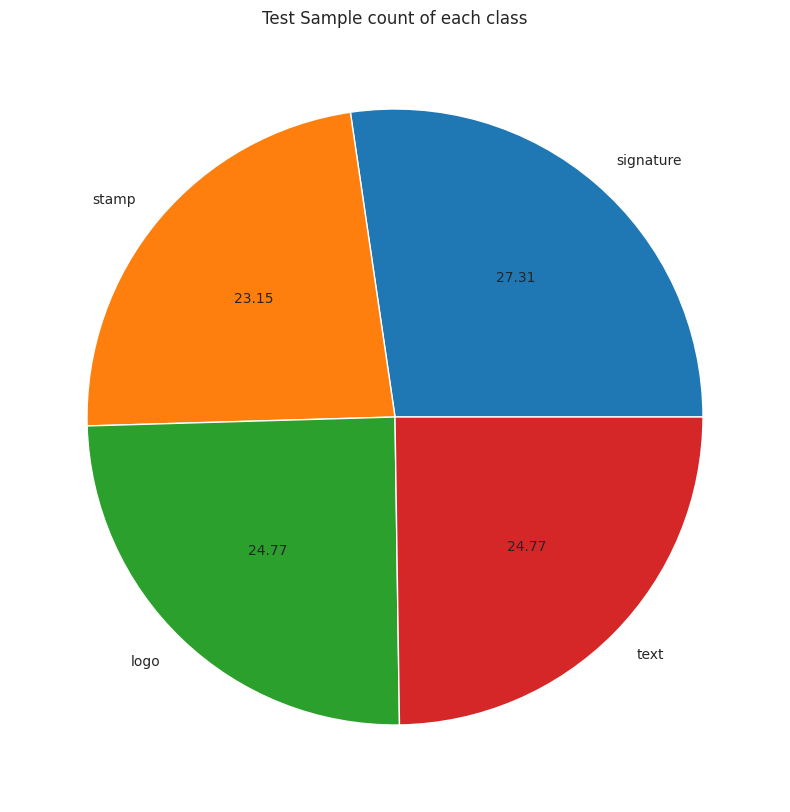

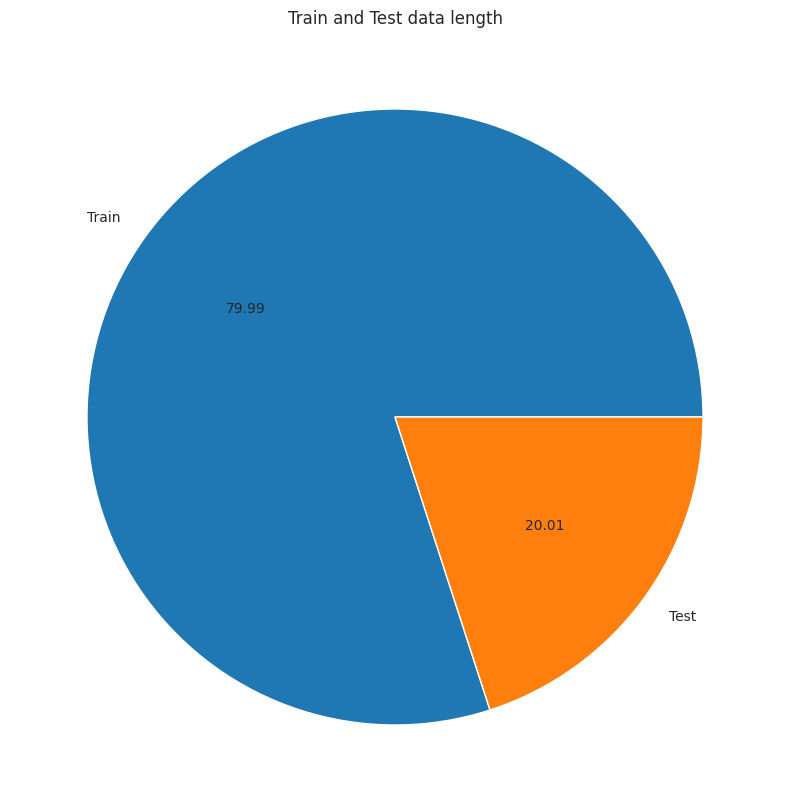

In [202]:
# display the sample count of each class with a bar graph
plt.figure(figsize=(10, 10))
plt.bar(x=class_names, height=np.bincount(y_train.argmax(axis=1)))
plt.title("Train Sample count of each class")
plt.show()

# display the sample count of each class with a bar graph
plt.figure(figsize=(10, 10))
plt.bar(x=class_names, height=np.bincount(y_test.argmax(axis=1)))
plt.title("Test Sample count of each class")
plt.show()


plt.figure(figsize=(10, 10))
plt.pie(x=np.bincount(y_train.argmax(axis=1)), labels=class_names, autopct="%.2f")
plt.title("Train Sample count of each class")
plt.show()


plt.figure(figsize=(10, 10))
plt.pie(x=np.bincount(y_test.argmax(axis=1)), labels=class_names, autopct="%.2f")
plt.title("Test Sample count of each class")
plt.show()


# len of train and test data as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(x=[len(x_train), len(x_test)], labels=["Train", "Test"], autopct="%.2f")
plt.title("Train and Test data length")
plt.show()


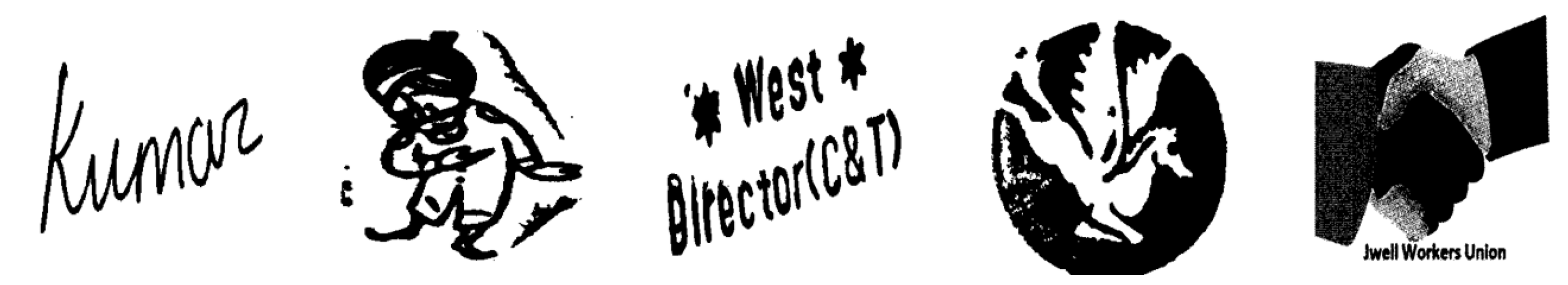

In [102]:
# show some images
plt.figure(figsize=(20, 20))
for i in range(0, 5):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[np.random.randint(0, x_train.shape[0])], cmap="gray")
    plt.axis("off")


In [7]:
model = Sequential()
model.add(Input(shape=(224, 224,3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization (Batch  (None, 220, 220, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 32)      9

2023-10-16 18:09:49.293675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:09:49.293722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:09:49.293735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:09:49.745830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-16 18:09:49.745867: I tensorflow/compile

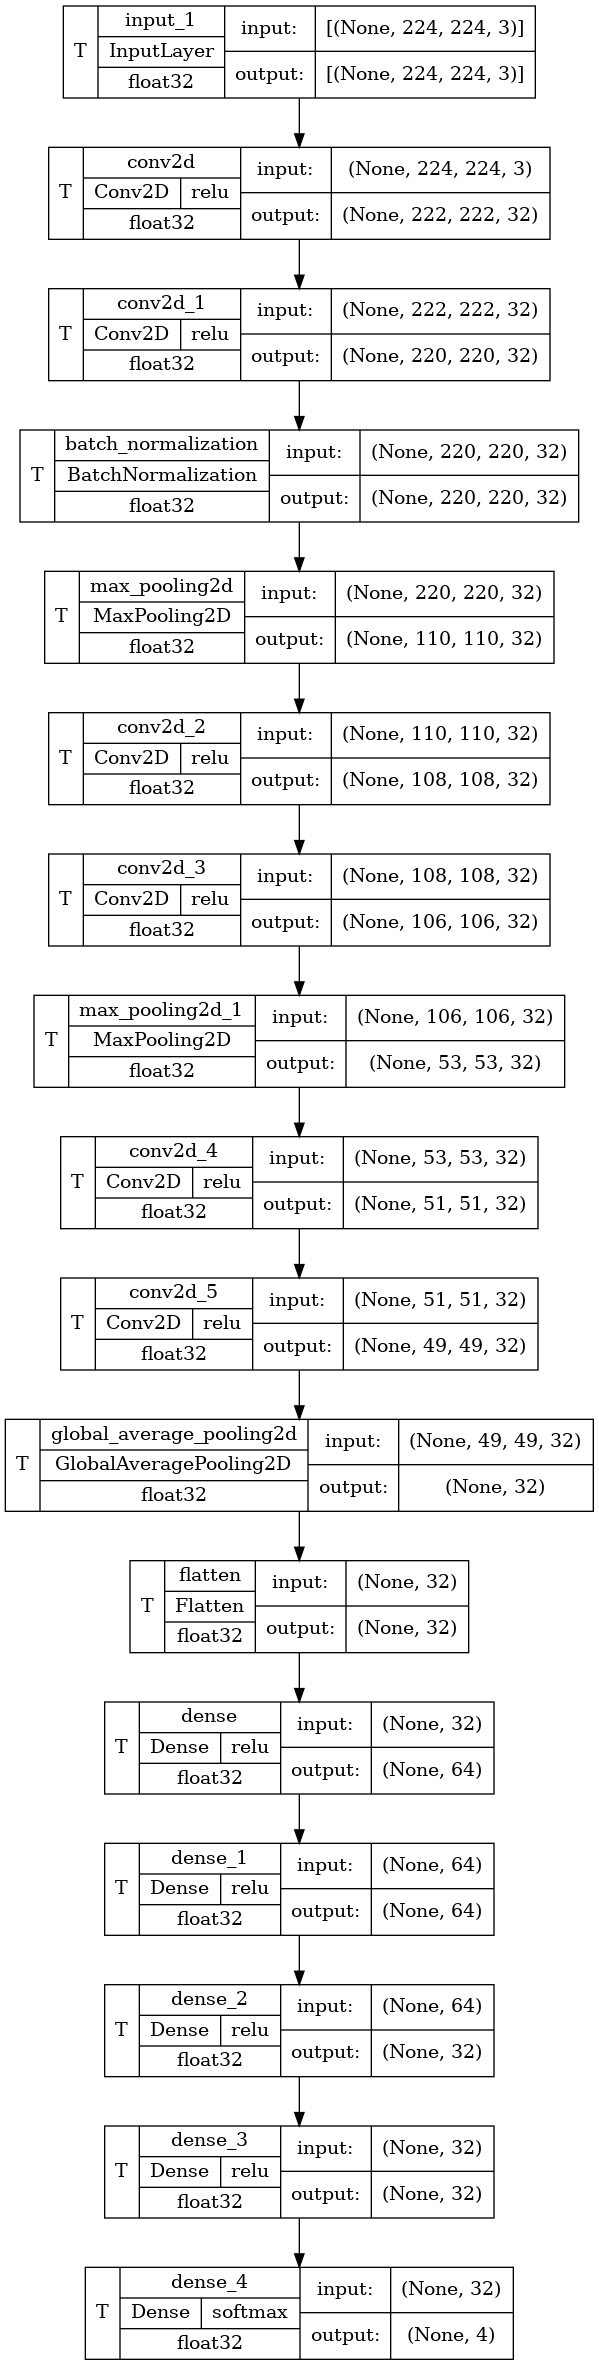

In [8]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,show_dtype=True,show_layer_activations=True,show_trainable=True)

In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy","Precision", "Recall"])

In [9]:
history = model.fit(x=image_data, y=labels,epochs=20,validation_split=0.2,shuffle=True,validation_data=(x_test, y_test))

Epoch 1/20


2023-10-16 18:10:02.868093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-16 18:10:04.237326: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd9a021ab40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-16 18:10:04.237375: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-10-16 18:10:04.240942: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-16 18:10:04.302761: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 [==============================] - 16s 74ms/step - loss: 0.6497 - accuracy: 0.7105 - precision: 0.8309 - recall: 0.5836 - val_loss: 11.0664 - val_accuracy: 0.3912 - val_precision: 0.3912 - val_recall: 0.3912
Epoch 2/20
135/135 [==============================] - 7s 54ms/step - loss: 0.2890 - accuracy: 0.8840 - precision: 0.8898 - recall: 0.8770 - val_loss: 0.1924 - val_accuracy: 0.9352 - val_precision: 0.9382 - val_recall: 0.9317
Epoch 3/20
135/135 [==============================] - 7s 54ms/step - loss: 0.2003 - accuracy: 0.9296 - precision: 0.9331 - recall: 0.9277 - val_loss: 0.1767 - val_accuracy: 0.9456 - val_precision: 0.9540 - val_recall: 0.9363
Epoch 4/20
135/135 [==============================] - 7s 54ms/step - loss: 0.1446 - accuracy: 0.9423 - precision: 0.9429 - recall: 0.9416 - val_loss: 0.0835 - val_accuracy: 0.9734 - val_precision: 0.9733 - val_recall: 0.9722
Epoch 5/20
135/135 [==============================] - 7s 54ms/step - loss: 0.1346 - accuracy: 0.9491 - precis

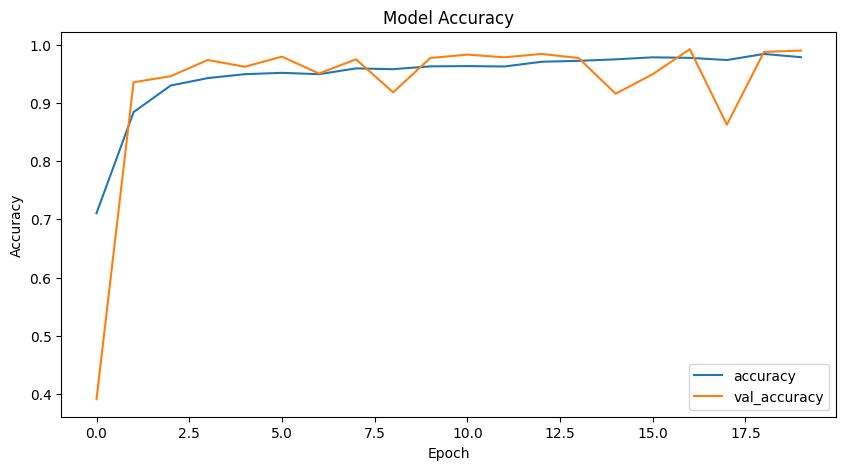

In [10]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

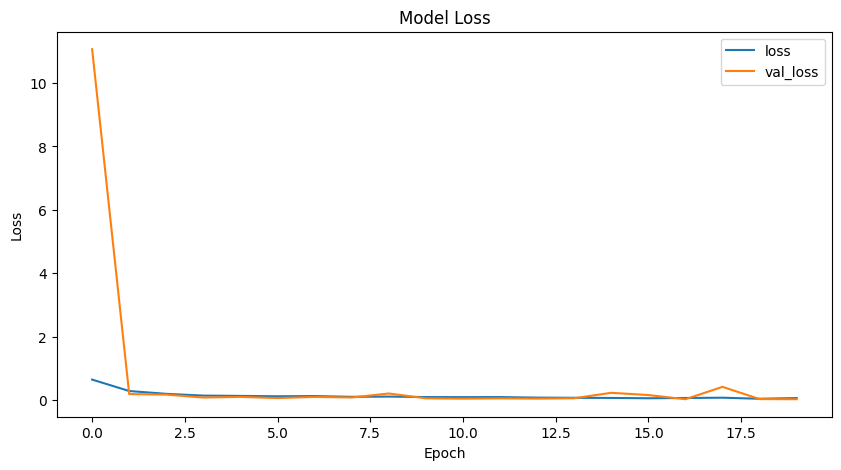

In [11]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix,classification_report

print("Deep Learning Confusion Matrix: ")
print(confusion_matrix([np.argmax(i) for i in y_test], np.argmax(model.predict(x_test), axis=-1)))
print("Deep Learning Classification Report: ")
print(classification_report([np.argmax(i) for i in y_test], np.argmax(model.predict(x_test), axis=-1)))

Deep Learning Confusion Matrix: 
27/27 [==============================] - 1s 32ms/step
[[236   0   0   0]
 [  0 195   5   0]
 [  0   0 214   0]
 [  0   3   1 210]]
Deep Learning Classification Report: 
27/27 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       236
           1       0.98      0.97      0.98       200
           2       0.97      1.00      0.99       214
           3       1.00      0.98      0.99       214

    accuracy                           0.99       864
   macro avg       0.99      0.99      0.99       864
weighted avg       0.99      0.99      0.99       864



27/27 [==============================] - 1s 26ms/step


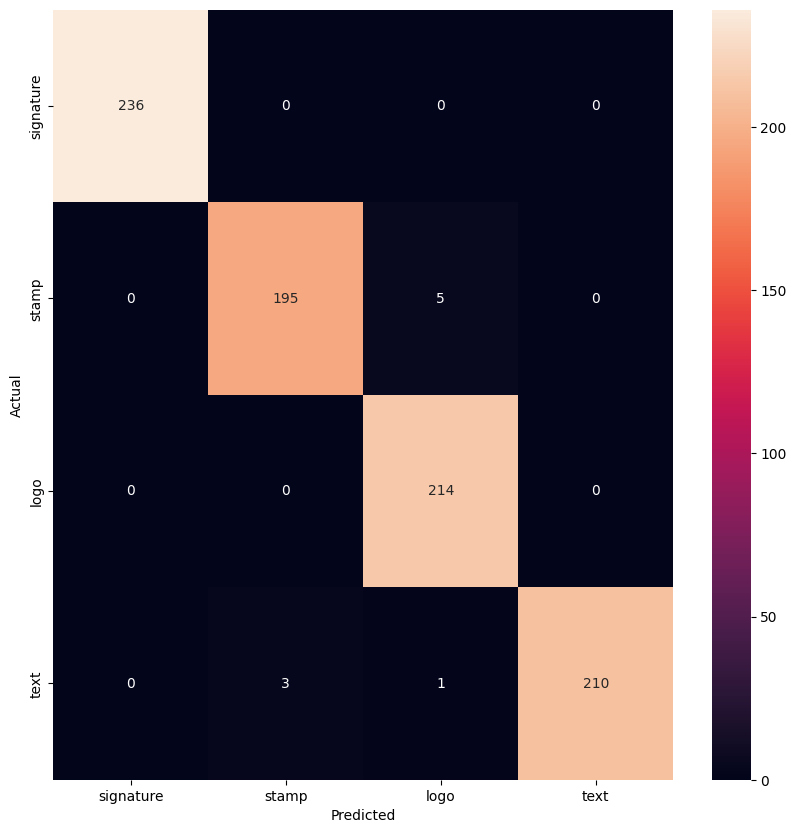

In [187]:
# display confusion matrix
names = ["signature", "stamp", "logo", "text"]
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix([np.argmax(i) for i in y_test], np.argmax(model.predict(x_test), axis=-1)), annot=True, xticklabels=names, yticklabels=names,fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [13]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

print("Deep Learning Accuracy Score: ",accuracy_score([np.argmax(i) for i in y_test], np.argmax(model.predict(x_test), axis=-1)))
print("Deep Learning Precision Score: ",precision_score([np.argmax(i) for i in y_test], np.argmax(model.predict(x_test), axis=-1),average='macro'))
print("Deep Learning Recall Score: ",recall_score([np.argmax(i) for i in y_test], np.argmax(model.predict(x_test), axis=-1),average='macro'))


27/27 [==============================] - 1s 27ms/step
Deep Learning Accuracy Score:  0.9895833333333334
27/27 [==============================] - 1s 19ms/step
Deep Learning Precision Score:  0.9893939393939394
27/27 [==============================] - 0s 18ms/step
Deep Learning Recall Score:  0.9890771028037384


27/27 [==============================] - 1s 19ms/step


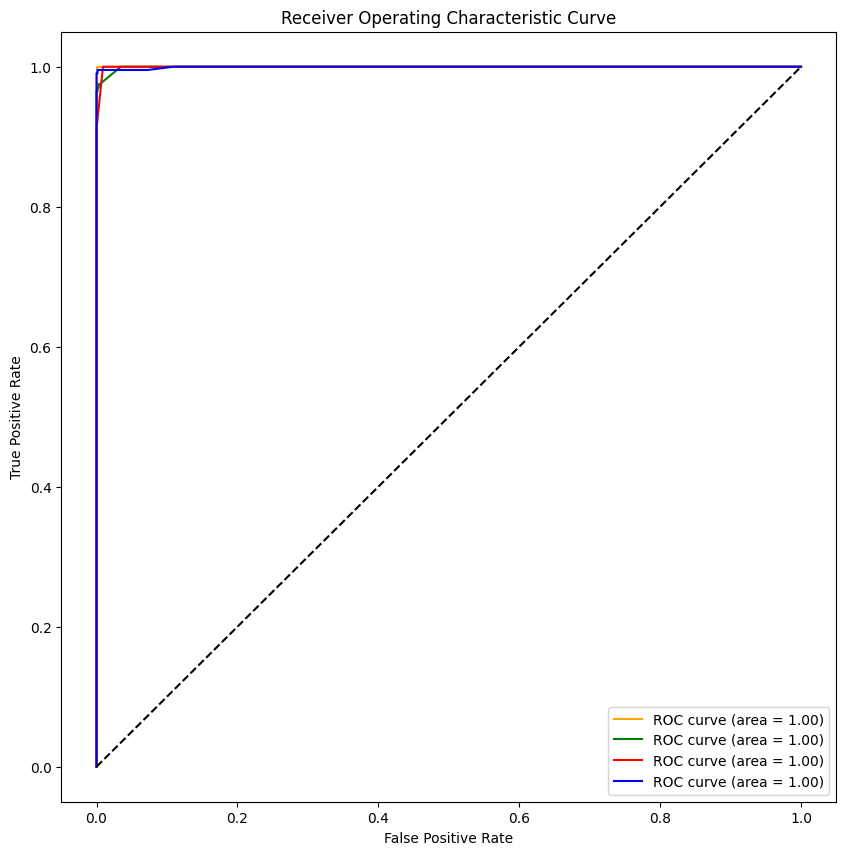

In [17]:
from sklearn.metrics import roc_curve,roc_auc_score

y_pred = model.predict(x_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])

plt.figure(figsize=(10,10))
plt.plot(fpr[0], tpr[0], color='orange', label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='red', label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='blue', label='ROC curve (area = %0.2f)' % roc_auc[3])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()


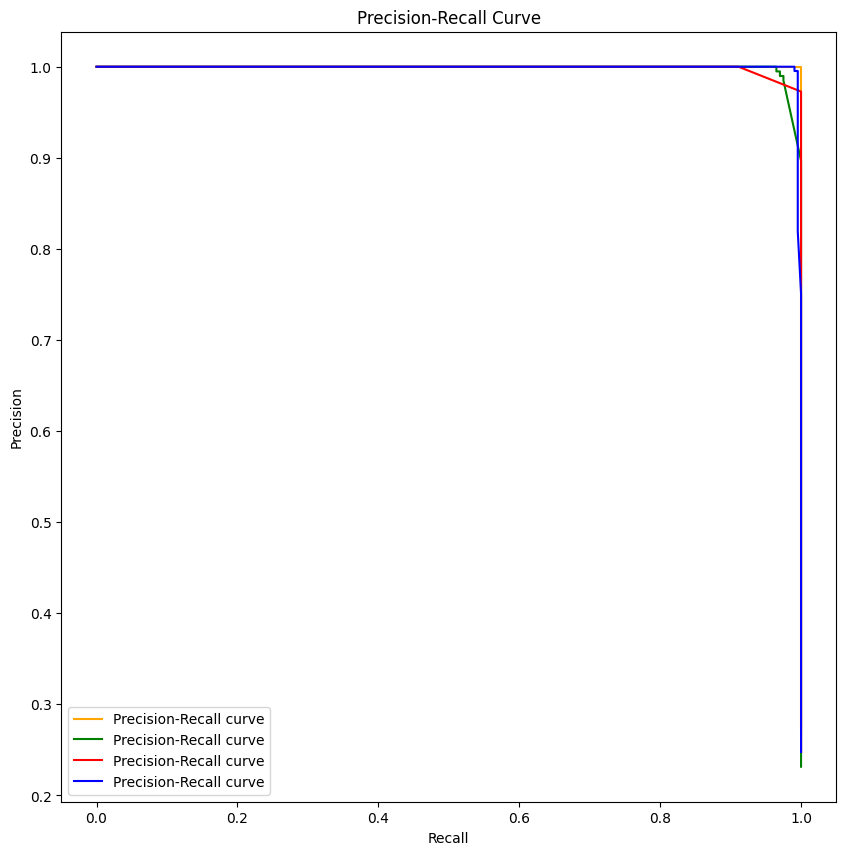

In [18]:
from sklearn.metrics import precision_recall_curve


precision = dict()
recall = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])

plt.figure(figsize=(10,10))
plt.plot(recall[0], precision[0], color='orange', label='Precision-Recall curve')
plt.plot(recall[1], precision[1], color='green', label='Precision-Recall curve')
plt.plot(recall[2], precision[2], color='red', label='Precision-Recall curve')
plt.plot(recall[3], precision[3], color='blue', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [19]:
model.save("signature.keras")

In [20]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
model = load_model("signature.keras")

In [175]:
def divide_image_into_parts(image, window_size=(224, 224),threshold=0.5):
  # check if image size is divisible by window size if not then pad the image
  if image.shape[0] % window_size[0] != 0:
    image = np.concatenate((image, np.ones((window_size[0] - image.shape[0] % window_size[0], image.shape[1], image.shape[2]))), axis=0)
  if image.shape[1] % window_size[1] != 0:
    image = np.concatenate((image, np.ones((image.shape[0], window_size[1] - image.shape[1] % window_size[1], image.shape[2]))), axis=1)
    
  # divide image into parts and predict each part and draw a rectangle on the image
  for i in tqdm(range(0, image.shape[0], window_size[0])):
    for j in range(0, image.shape[1], window_size[1]):
      part = image[i:i+window_size[0], j:j+window_size[1]]
      part = cv2.resize(part, (224, 224))
      part = np.expand_dims(part, axis=0)
      pred = model.predict(part,verbose=0)
      class_type = np.argmax(pred)
      
      if class_type == 0 and pred[0][0] > threshold:
        color = (255, 0, 0)
        cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
      elif class_type == 1 and pred[0][1] > threshold:
        # color = (0, 255, 0)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      elif class_type == 2 and pred[0][2] > threshold:
        # color = (0, 0, 255)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      elif class_type == 3 and pred[0][3] > threshold:
        # color = (255, 255, 0)
        # cv2.rectangle(image, (j, i), (j+window_size[1], i+window_size[0]), color, 2)
        pass
      else:
        pass

  return  image

100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


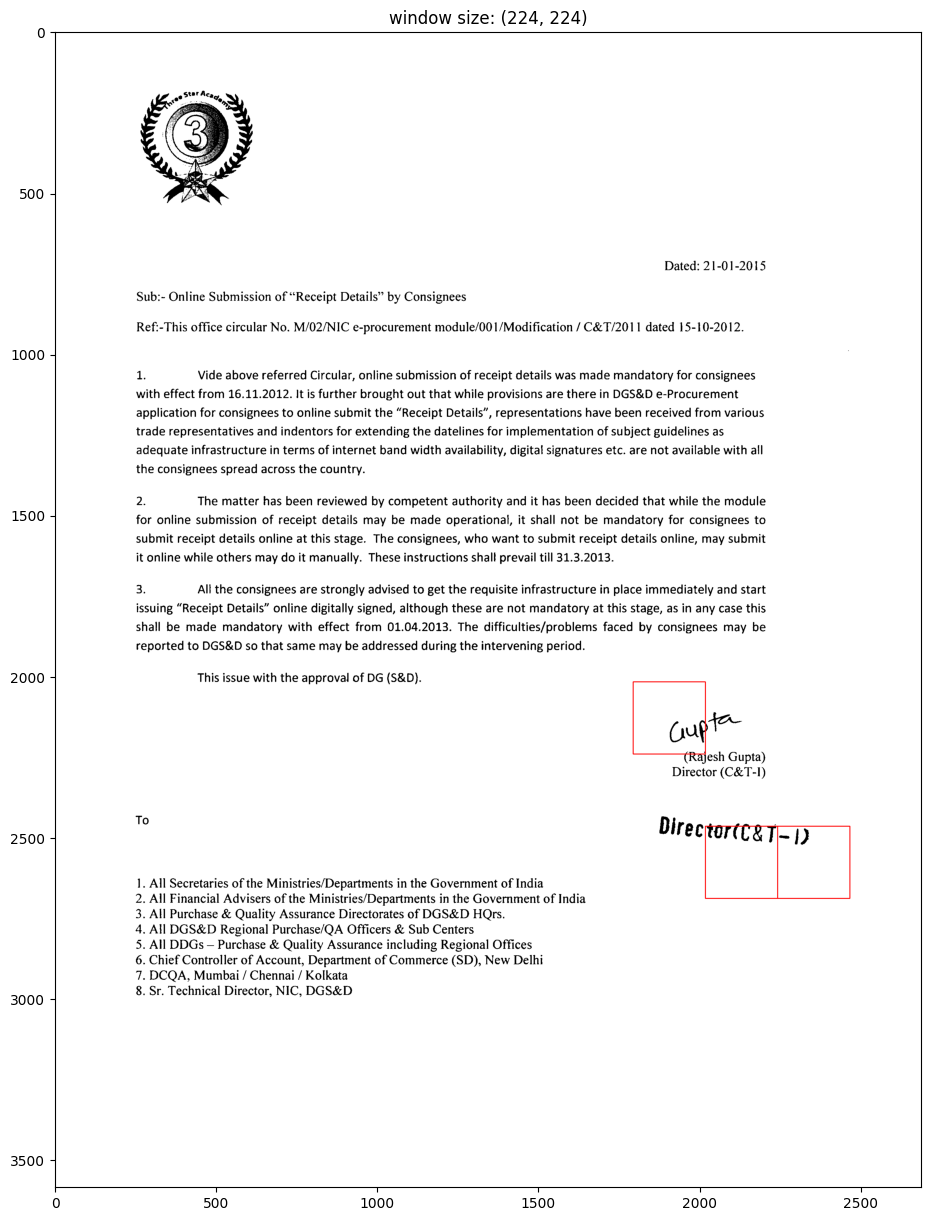

100%|██████████| 16/16 [00:07<00:00,  2.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


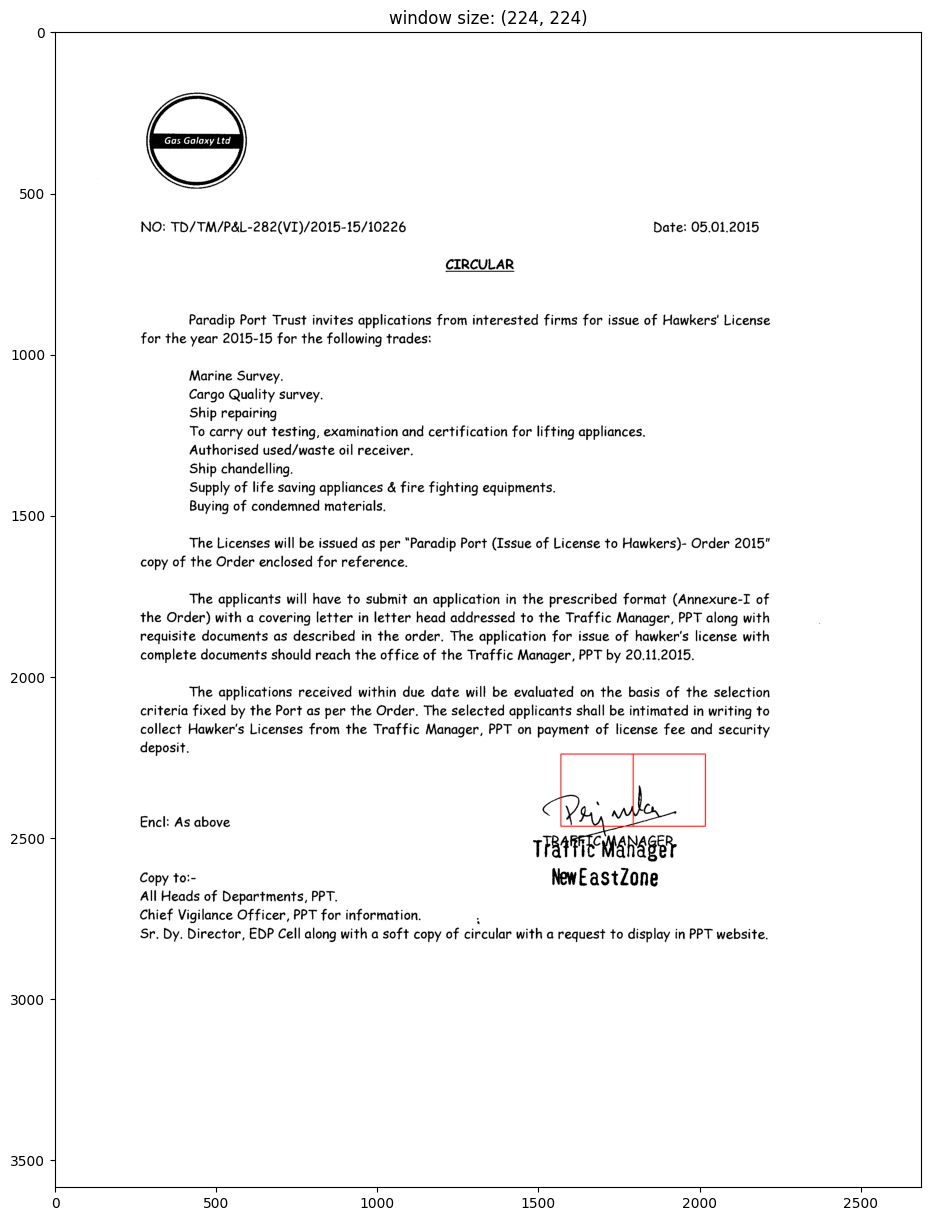

100%|██████████| 16/16 [00:07<00:00,  2.28it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


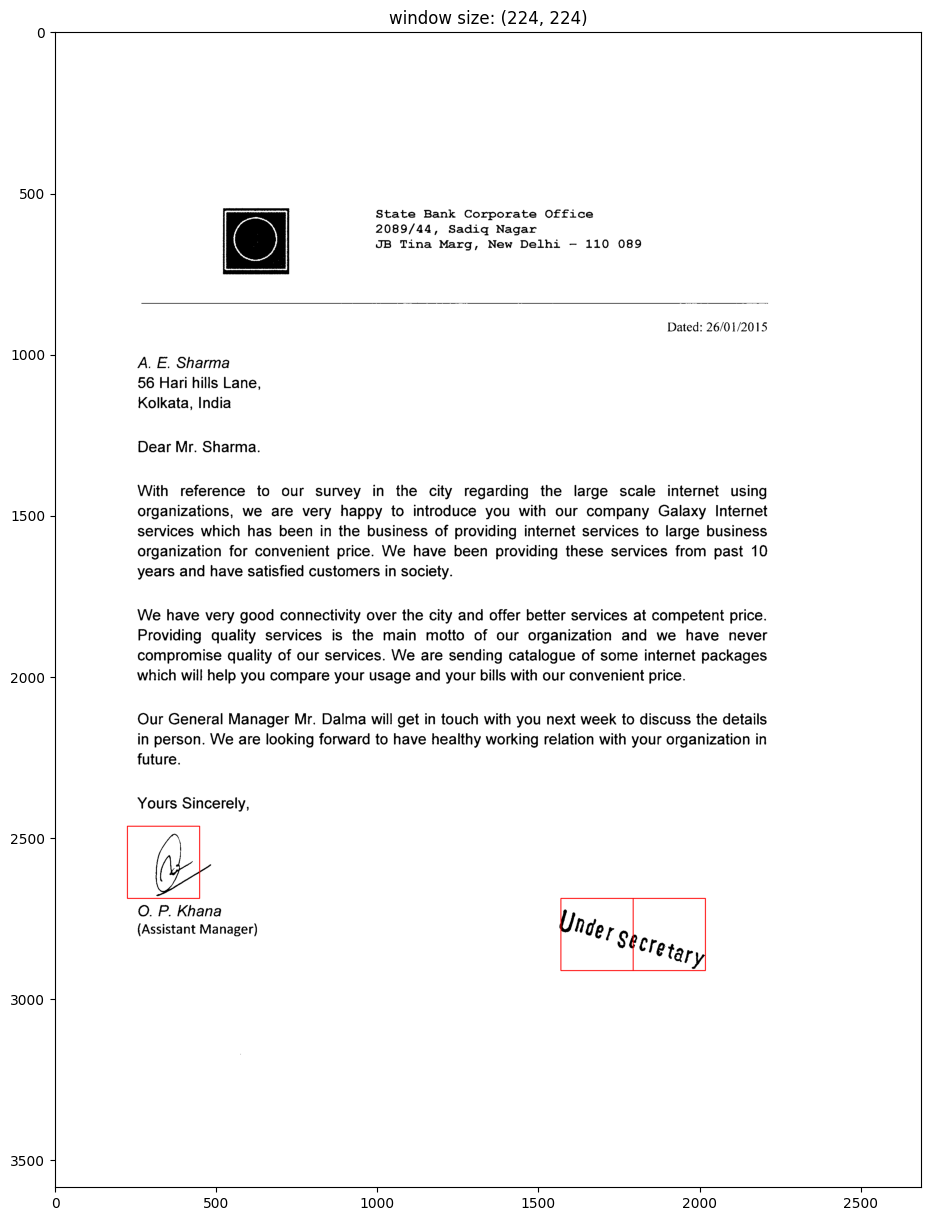

In [191]:
images = ["SPODS_Dataset/image (430).png","SPODS_Dataset/image (530).png","SPODS_Dataset/image (790).png"]
windows = [(224,224)]
for image in images:
  image = cv2.imread(image,)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret, image = cv2.threshold(image, 160, 255, cv2.THRESH_BINARY)
  image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
  for window in windows:
    image_copy = image.copy()
    image_copy = divide_image_into_parts(image_copy, window,threshold=0.97)
    plt.figure(figsize=(15, 15))
    plt.imshow(image_copy)
    plt.title(f"window size: {window}")
    plt.show()

